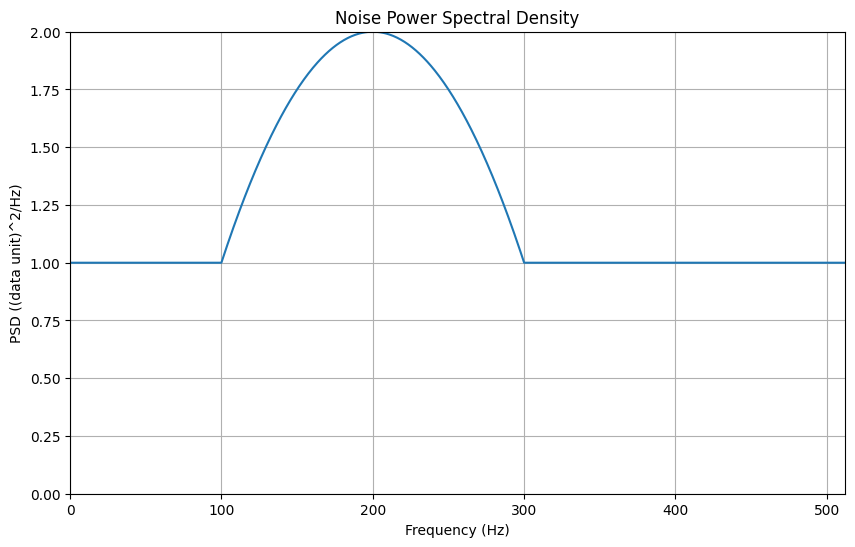

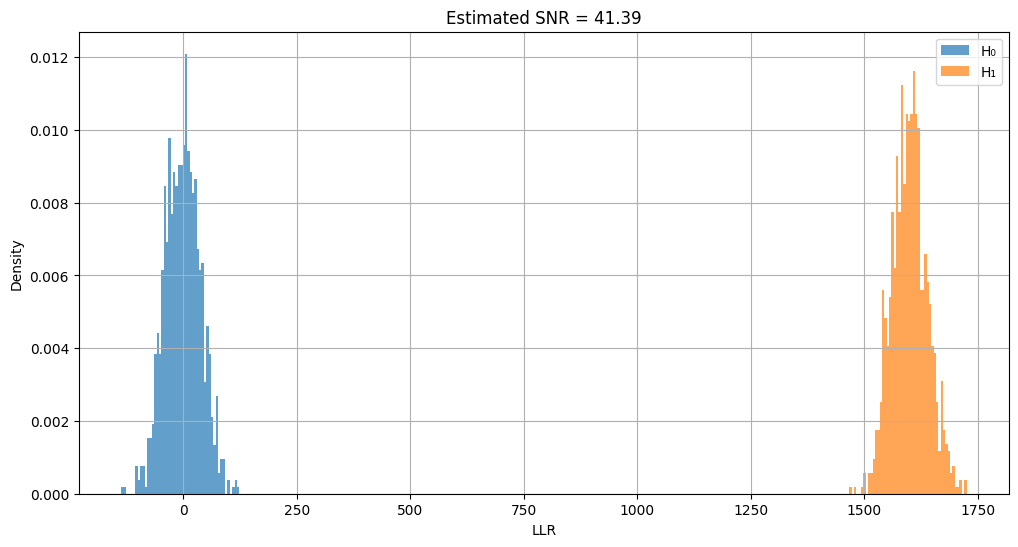

Target SNR: 40
Estimated SNR: 41.39
Mean LLR H0: -1.5126
Mean LLR H1: 1599.8364
Std LLR H0: 38.6915


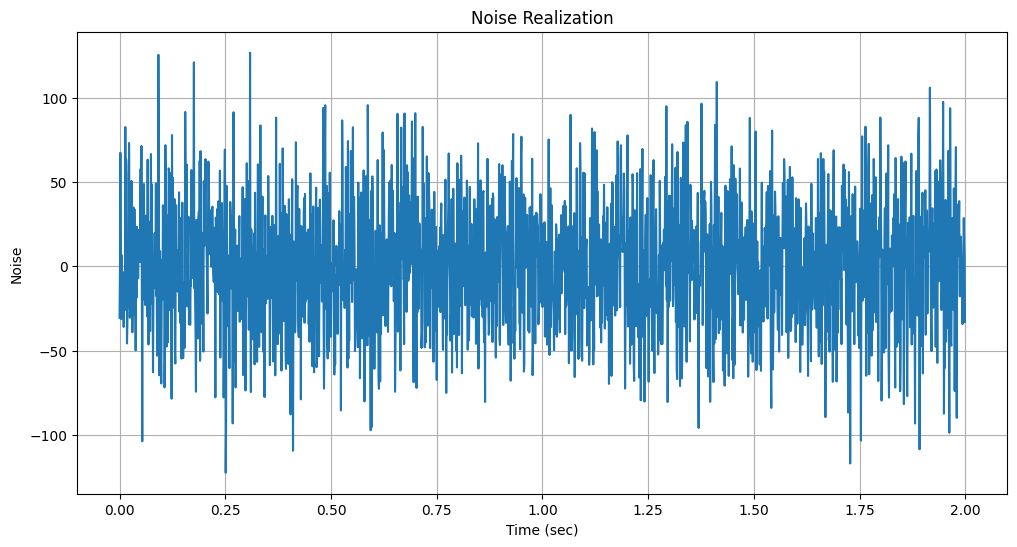

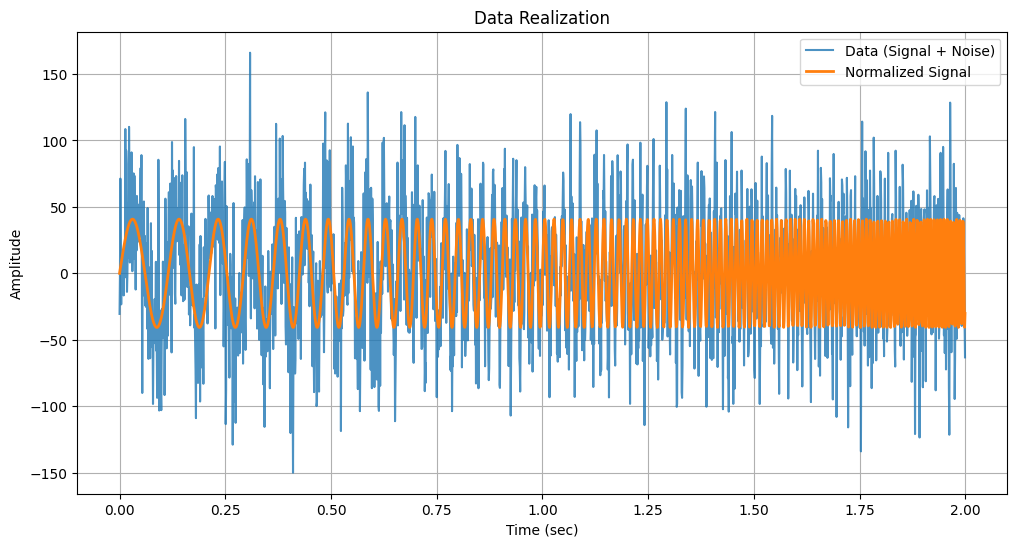

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import signal

from function import crcbgenqcsig, statgaussnoisegen, innerprod_psd, normsig4psd

## for estimating the SNR of the LR test (binary hypotheses) from multiple data realizations

# Target SNR for the LR
snr = 40

# Data generation parameters
n_samples = 2048
samp_freq = 1024
time_vec = np.arange(n_samples) / samp_freq

# Generate the signal that is to be normalized
a1, a2, a3 = 8, 5, 9
A = 1  # Amplitude value does not matter as it will be changed in normalization
sig_vec = crcbgenqcsig(time_vec, A, [a1, a2, a3])

# Define noise PSD function
def noise_psd(f):
    return ((f >= 100) & (f <= 300)) * (f - 100) * (300 - f) / 10000 + 1

# Generate the PSD vector for normalization
data_len = n_samples / samp_freq
k_nyq = n_samples // 2 +1
pos_freq = np.arange(k_nyq) / data_len
psd_pos_freq = noise_psd(pos_freq)

# Plot PSD
plt.figure(figsize=(10, 6))
plt.plot(pos_freq, psd_pos_freq)
plt.xlim(0, pos_freq[-1])
plt.ylim(0, np.max(psd_pos_freq))
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((data unit)^2/Hz)')
plt.title('Noise Power Spectral Density')
plt.grid(True)
plt.show()

# Calculation of the norm
# Norm of signal squared is inner product of signal with itself
# print('signal_vec shape:', sig_vec.shape)
norm_sig_sqrd = innerprod_psd(sig_vec, sig_vec, samp_freq, psd_pos_freq)
# print(f"Signal norm squared: {norm_sig_sqrd}")

# Normalize signal to specified SNR
sig_vec = snr * sig_vec / np.sqrt(norm_sig_sqrd)
# print(f"Signal normalized to SNR: {snr}")

# Test: Obtain LLR values for multiple noise realizations (H0)
n_h0_data = 1000
llr_h0 = np.zeros(n_h0_data)

for lp in range(n_h0_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 100, samp_freq)
    llr_h0[lp] = innerprod_psd(noise_vec, sig_vec, samp_freq, psd_pos_freq)

# Obtain LLR for multiple data (signal + noise) realizations (H1)
n_h1_data = 1000
llr_h1 = np.zeros(n_h1_data)

for lp in range(n_h1_data):
    noise_vec = statgaussnoisegen(n_samples, np.column_stack([pos_freq, psd_pos_freq]), 200, samp_freq)
    # Add normalized signal
    data_vec = noise_vec + sig_vec
    llr_h1[lp] = innerprod_psd(data_vec, sig_vec, samp_freq, psd_pos_freq)

# Signal to noise ratio estimate
est_snr = (np.mean(llr_h1) - np.mean(llr_h0)) / np.std(llr_h0)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(llr_h0, bins=50, alpha=0.7, label='H₀', density=True)
plt.hist(llr_h1, bins=50, alpha=0.7, label='H₁', density=True)
plt.xlabel('LLR')
plt.ylabel('Density')
plt.legend()
plt.title(f'Estimated SNR = {est_snr:.2f}')
plt.grid(True)
plt.show()

print(f"Target SNR: {snr}")
print(f"Estimated SNR: {est_snr:.2f}")
print(f"Mean LLR H0: {np.mean(llr_h0):.4f}")
print(f"Mean LLR H1: {np.mean(llr_h1):.4f}")
print(f"Std LLR H0: {np.std(llr_h0):.4f}")

# Plot a noise realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec, noise_vec)
plt.xlabel('Time (sec)')
plt.ylabel('Noise')
plt.title('Noise Realization')
plt.grid(True)
plt.show()

# Plot a data realization
plt.figure(figsize=(12, 6))
plt.plot(time_vec, data_vec, label='Data (Signal + Noise)', alpha=0.8)
plt.plot(time_vec, sig_vec, label='Normalized Signal', linewidth=2)
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.title('Data Realization')
plt.legend()
plt.grid(True)
plt.show()




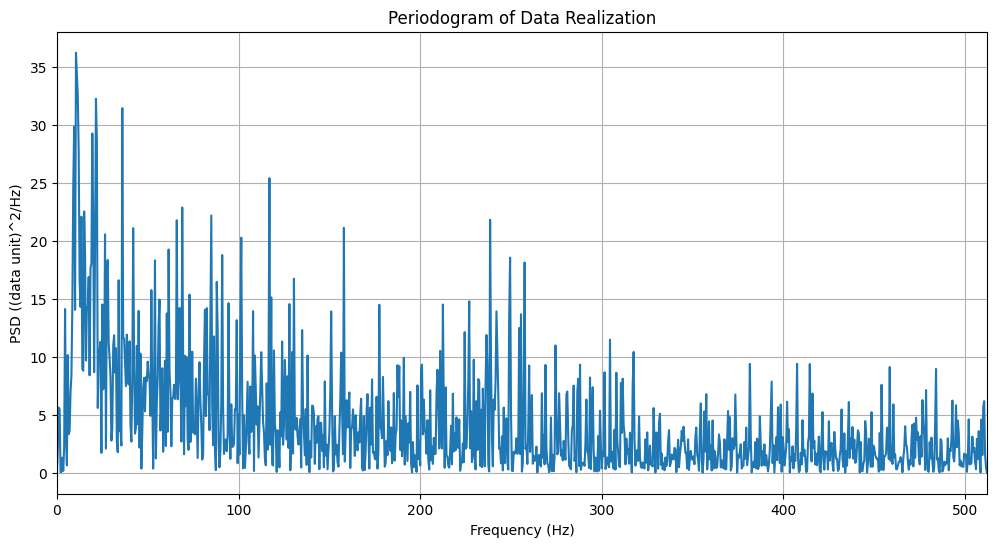

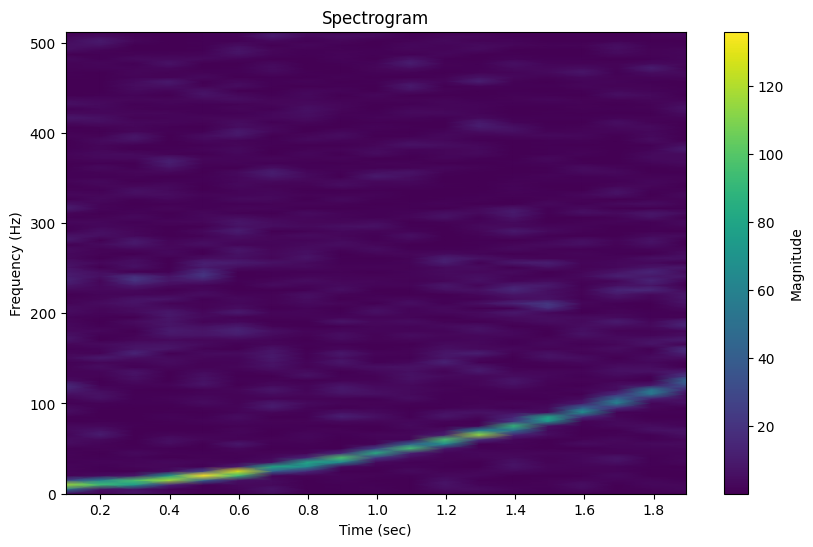

In [57]:
#Plot the periodogram of the data realization
f, Pxx = signal.periodogram(data_vec, samp_freq)
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD ((data unit)^2/Hz)')
plt.title('Periodogram of Data Realization')
plt.xlim(0, samp_freq / 2)
plt.grid(True)
plt.show()

# Compute the spectrogram and plot
winLen = 0.2  # sec
ovrlp = 0.1  # sec
winLenSmpls = int(np.floor(winLen * samp_freq))# Convert to integer number of samples
ovrlpSmpls = int(np.floor(ovrlp * samp_freq))
f, t, Sxx = signal.spectrogram(data_vec, fs=samp_freq, window='hann', nperseg=winLenSmpls, noverlap=ovrlpSmpls)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.abs(Sxx), shading='gouraud')
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude')
plt.show()
